In [81]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import seaborn as sns

sns.set(color_codes=True, style="white")

### Load Data

In [82]:
folder_FUS_FL = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig4_regulation/FUS488_miR21_PAINT"
os.chdir(folder_FUS_FL)
dict_perDomain = pickle.load(open("PairCorr-DataDict-pooled-perDomain.p", "rb"))

In [83]:
# Assume the following parameters are the same for all PairCorr-DataDict.p
nm_per_pxl = dict_perDomain["nm_per_pxl"]
r_max_nm = dict_perDomain["r_max_nm"]
ringwidth_nm = dict_perDomain["ringwidth_nm"]
dr_slidingrings_nm = dict_perDomain["dr_slidingrings_nm"]
bins = dict_perDomain["bins"]
dict_perDomain.keys()

dict_keys(['filenames_FUS', 'filenames_RNA', 'lst_N_locations_FUS', 'lst_N_locations_RNA', 'lst_cross_PCF_FUSref', 'lst_auto_PCF_FUS', 'lst_df_FUSdomains', 'nm_per_pxl', 'r_max_nm', 'ringwidth_nm', 'dr_slidingrings_nm', 'bins'])

### Functions

In [84]:
def weighted_stats(lst_PCF_per_condensate, lst_N_locations):
    # create arrays for weighted means, SEMs and STDs
    N_condensates = len(lst_N_locations)
    N_bins = lst_PCF_per_condensate[0].shape[0]
    weighted_mean = np.zeros(N_bins)
    weighted_sem = np.zeros(N_bins)
    weighted_std = np.zeros(N_bins)
    weights = np.array(lst_N_locations)

    # iterate over the length of a numpy array in the list
    for i in range(N_bins):
        # extract the i-th element from each array and their respective weight
        data_array = np.array(
            [lst_PCF_per_condensate[j][i] for j in range(N_condensates)]
        )
        # calculate the weighted mean
        weighted_mean[i] = np.average(data_array, weights=weights)
        # calculate the variance
        variance = np.average((data_array - weighted_mean[i]) ** 2, weights=weights)
        # calculate the weighted SEM
        weighted_sem[i] = np.sqrt(variance / N_condensates)
        # calculate the weighted STD
        weighted_std[i] = np.sqrt(variance)

    return weighted_mean, weighted_sem, weighted_std

def critical_system_PCF(r, A, characteristic_size):
     Gr = 1 + A * np.exp(- r / characteristic_size)
     return Gr

### Domain distribution in condensate

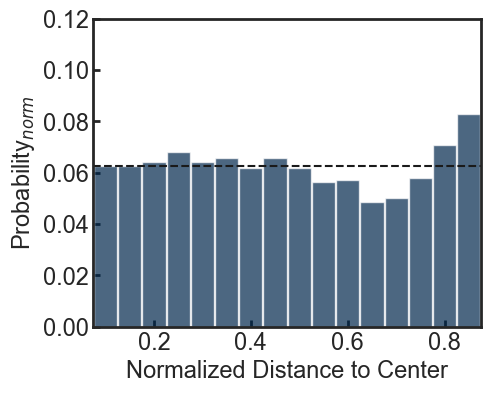

In [85]:
lst_df_FUSdomains = dict_perDomain["lst_df_FUSdomains"]
lst_d2center_norm = [df["d2center_norm"].to_numpy(float) for df in lst_df_FUSdomains]
d2center_norm = np.hstack(lst_d2center_norm)

r_max = 1
ringwidth = 0.2
dr_slidingrings = 0.05
bin_starts = np.arange(0, r_max - ringwidth, dr_slidingrings)
bin_ends = bin_starts + ringwidth
ring_areas = np.pi * (bin_ends**2 - bin_starts**2)

# calculate histogram
lst_hist = []
for distance in d2center_norm[d2center_norm <= r_max]:
    lst_hist.append(((bin_starts <= distance) & (bin_ends >= distance)) * 1)
hist = np.sum(lst_hist, axis=0)

# determine normalization factors
N_domains = d2center_norm[d2center_norm <= r_max].shape[0]
rho_per_unit_circle = N_domains / (np.pi * 1**2)
norm_factors = ring_areas * rho_per_unit_circle
distribution = hist / norm_factors
probability_norm = distribution / distribution.sum()

plt.figure(figsize=(5, 4))
plt.axhline(1/len(bin_starts), c="k", ls="--")
bar_x = (bin_starts + bin_ends) / 2
plt.bar(
    bar_x,
    probability_norm,
    color="#00274c",
    width=0.048,
    alpha=0.7,
)
plt.xlim(bar_x[0] - dr_slidingrings / 2, bar_x[-1] + dr_slidingrings / 2)
plt.ylim(0, 0.12)
plt.xlabel("Normalized Distance to Center", fontsize=17)
plt.ylabel(r"Probability$_{norm}$", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "FUS_domain_radial_distribution.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### autoFUS individual

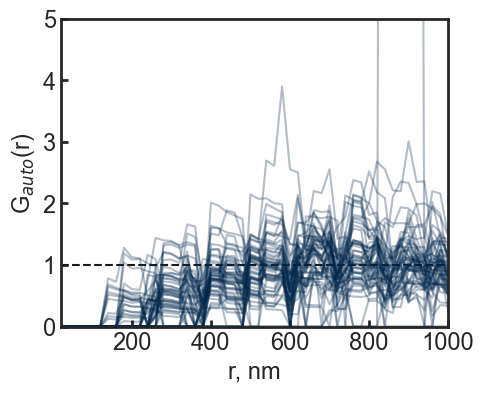

In [86]:
# Plot individual curves for perDomain
lst_PCF_per_condensate = dict_perDomain["lst_auto_PCF_FUS"]

plt.figure(figsize=(5, 4))
plt.axhline(1, c="k", ls="--")
for current_PCF in lst_PCF_per_condensate:
    plt.plot(bins, current_PCF, c="#00274c", alpha=0.3)
plt.xlim(bins[1], bins[-1])
plt.ylim(0, 5)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{auto}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "autoFUS_PCF_perDomain_individual.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### autoFUS weighted mean, STD

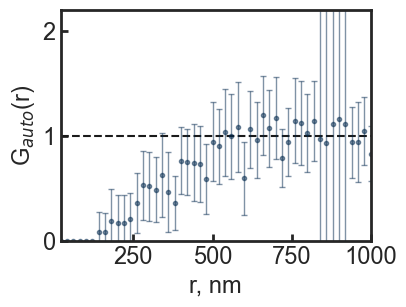

In [87]:
# Calculate the weighted mean, STD, SEM
lst_PCF_per_condensate = dict_perDomain["lst_auto_PCF_FUS"]
lst_N_locations = dict_perDomain["lst_N_locations_FUS"]

weighted_mean, weighted_sem, weighted_std = weighted_stats(
    lst_PCF_per_condensate, lst_N_locations
)
# Plot weighted mean curves + STD
plt.figure(figsize=(4, 3))
plt.axhline(1, c="k", ls="--")
plt.errorbar(
    bins,
    weighted_mean,
    yerr=weighted_std,
    fmt=".",
    color="#00274c",
    ecolor="#00274c",
    elinewidth=1,
    capsize=2,
    alpha=0.5,
)
plt.xlim(bins[1], bins[-1])
plt.ylim(0, 2.2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{auto}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "autoFUS_PCF_perDomain_weighted_mean_STD.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### cross individual

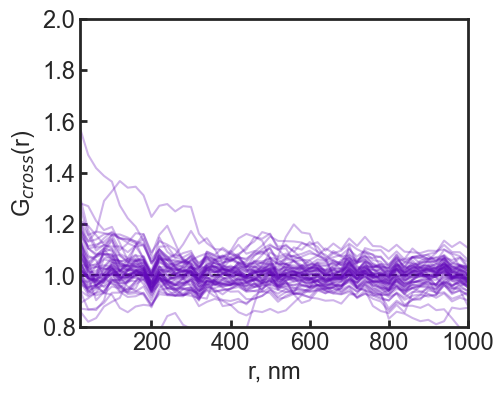

In [88]:
# Plot individual curves for perDomain
lst_PCF_per_condensate = dict_perDomain['lst_cross_PCF_FUSref']
plt.figure(figsize=(5, 4))
plt.axhline(1, c="k", ls="--")
for current_PCF in lst_PCF_per_condensate:
    plt.plot(bins, current_PCF, c="#6209ba", alpha=0.3)
plt.xlim(bins[1], bins[-1])
plt.ylim(0.8, 2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{cross}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "cross_PCF_FUSref_perDomain_individual.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### cross weighted mean + STD

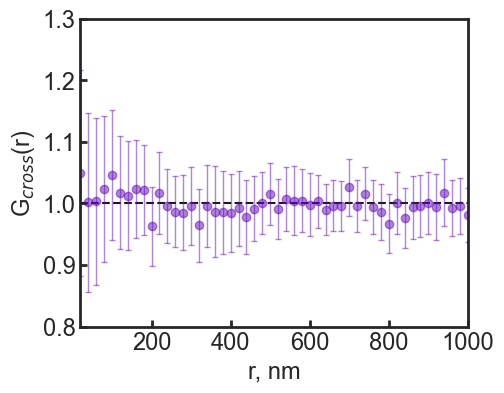

In [89]:
# Calculate the weighted mean, STD, SEM
lst_PCF_per_condensate = dict_perDomain["lst_cross_PCF_FUSref"]
lst_N_locations_FUS = dict_perDomain["lst_N_locations_FUS"]
lst_N_locations_RNA = dict_perDomain["lst_N_locations_RNA"]
lst_N_locations = [a + b for a, b in zip(lst_N_locations_FUS, lst_N_locations_RNA)]

weighted_mean, weighted_sem, weighted_std = weighted_stats(
    lst_PCF_per_condensate, lst_N_locations
)

# Plot weighted mean curves + STD
plt.figure(figsize=(5, 4))
plt.axhline(1, c="k", ls="--")
plt.errorbar(
    bins,
    weighted_mean,
    yerr=weighted_std,
    fmt="o",
    color="#6209ba",
    ecolor="#6209ba",
    elinewidth=1,
    capsize=2,
    alpha=0.5,
)
plt.xlim(bins[1], bins[-1])
plt.ylim(0.8, 1.3)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{cross}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "cross_PCF_FUSref_perDomain_weighted_mean_STD.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)